In [54]:
import pandas as pd
import geopandas as gpd

data = pd.read_csv('e:\\Data\\2017-18-crdc-data\\2017-18 Public-Use Files\\Data\\LEA\\CRDC\\CSV\\LEA Characteristics.csv', encoding='cp1252')
data['LEAID'] = data['LEAID'].astype(str)
data['LEAID'] = data['LEAID'].apply(lambda x: str(x)[2:].lstrip('0'))


data2 = pd.read_excel('e:\\Data\\ussd17.xls', skiprows=2)
data2.rename(columns={data2.columns[-1]: "Children in Poverty", 'District ID': 'LEAID', 'State Postal Code': 'LEA_STATE'}, inplace=True)

gdf = gpd.read_file('e:\Data\EDGE_GEOCODE_PUBLICLEA_1718\EDGE_GEOCODE_PUBLICLEA_1718\EDGE_GEOCODE_PUBLICLEA_1718.shp')
gdf['LEAID'] = gdf['LEAID'].apply(lambda x: str(x)[2:].lstrip('0'))
gdf.rename(columns={'STATE': 'LEA_STATE', 'ZIP': 'LEA_ZIP'}, inplace=True)

print(data.info())
#print(data2.info())
#print(gdf.info())
#data.head()
#data2.head()
#gdf.head()
#print("Number of unique LEAID in data: ", data['LEAID'].nunique())
#print("Number of unique LEAID in data2: ", data2['LEAID'].nunique())
#print("Number of unique LEAID in gdf: ", gdf['LEAID'].nunique())

#print("5 most repeated LEAID in data: \n", data['LEAID'].value_counts().head(5))
#print("5 most repeated LEAID in data2: \n", data2['LEAID'].value_counts().head(5))
#print("Rows from data where LEAID is 3060: \n", data[data['LEAID'] == '3060'])

#print("Rows from gdf where LEAID is 82 and LEA_STATE is AZ: \n", gdf[(gdf['LEAID'] == '82') & (gdf['LEA_STATE'] == 'AZ')])




C:\Users\Christian\AppData\Local\Temp\ipykernel_31096\4238262328.py:4: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('e:\\Data\\2017-18-crdc-data\\2017-18 Public-Use Files\\Data\\LEA\\CRDC\\CSV\\LEA Characteristics.csv', encoding='cp1252')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17604 entries, 0 to 17603
Data columns (total 53 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   LEA_STATE             17604 non-null  object
 1   LEA_STATE_NAME        17604 non-null  object
 2   LEAID                 17604 non-null  object
 3   LEA_NAME              17604 non-null  object
 4   LEA_ADDRESS           17604 non-null  object
 5   LEA_CITY              17604 non-null  object
 6   LEA_ZIP               17604 non-null  object
 7   CJJ                   17604 non-null  object
 8   LEA_ENR               17604 non-null  int64 
 9   LEA_ENR_NONLEAFAC     17604 non-null  int64 
 10  LEA_SCHOOLS           17604 non-null  int64 
 11  LEA_CRCOORD_SEX_IND   17604 non-null  object
 12  LEA_CRCOORD_RAC_IND   17604 non-null  object
 13  LEA_CRCOORD_DIS_IND   17604 non-null  object
 14  LEA_CRCOORD_SEX_FN    17602 non-null  object
 15  LEA_CRCOORD_SEX_LN    17602 non-null

In [61]:
data2['LEAID'] = data2['LEAID'].astype(str)
merged_data = pd.merge(data[['LEAID', 'LEA_STATE', 'LEA_ZIP', 'LEA_ENR']], data2[['LEAID', 'LEA_STATE','Children in Poverty']], on=['LEAID', 'LEA_STATE'])
merged_data = pd.merge(merged_data, gdf[['LEAID', 'LEA_STATE', 'LEA_ZIP', 'LAT', 'LON']], on=['LEAID', 'LEA_STATE', 'LEA_ZIP'])

merged_data['Pov Rate'] = merged_data['Children in Poverty'] / merged_data['LEA_ENR']


#print(merged_data.head())
print(merged_data.info())

if len(merged_data) == len(merged_data.drop_duplicates(['LEAID', 'LEA_STATE', 'LEA_ZIP'])):
    print("Every LEAID and LEA_STATE combination is unique.")
else:
    print("Every LEAID and LEA_STATE combination is not unique.")
    duplicates = merged_data[merged_data.duplicated(['LEAID', 'LEA_STATE', 'LEA_ZIP'], keep=False)]
    print("The duplicated LEAID and LEA_STATE combinations are:")
    print(duplicates[['LEAID', 'LEA_STATE']])




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11568 entries, 0 to 11567
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   LEAID                11568 non-null  object 
 1   LEA_STATE            11568 non-null  object 
 2   LEA_ZIP              11568 non-null  object 
 3   LEA_ENR              11568 non-null  int64  
 4   Children in Poverty  11568 non-null  int64  
 5   LAT                  11568 non-null  float64
 6   LON                  11568 non-null  float64
 7   Pov Rate             11568 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 723.1+ KB
None
Every LEAID and LEA_STATE combination is unique.


Count of unique LEAIDs in TX:  1021


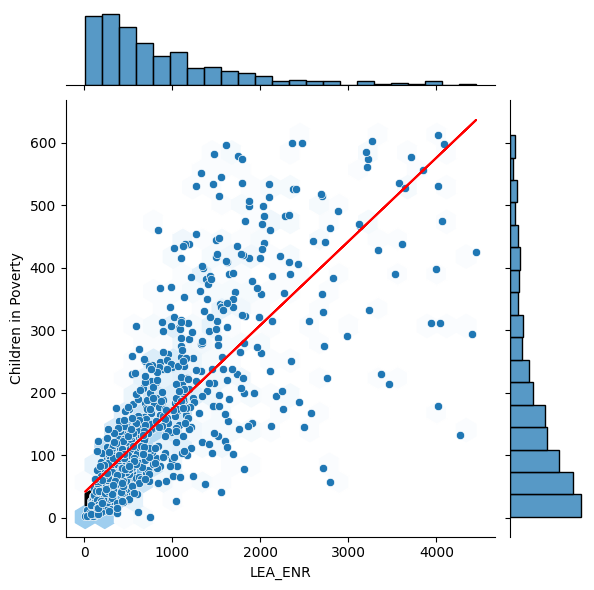

In [7]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

tx_data = merged_data[merged_data['LEA_STATE'] == 'TX']
print("Count of unique LEAIDs in TX: ", tx_data['LEAID'].nunique())


Q1 = tx_data['LEA_ENR'].quantile(0.25)
Q3 = tx_data['LEA_ENR'].quantile(0.75)
IQR = Q3 - Q1
tx_data = tx_data[~((tx_data['LEA_ENR'] < (Q1 - .5 * IQR)) | (tx_data['LEA_ENR'] > (Q3 + .5 * IQR)))]

Q1 = tx_data['Children in Poverty'].quantile(0.25)
Q3 = tx_data['Children in Poverty'].quantile(0.75)
IQR = Q3 - Q1
tx_data = tx_data[~((tx_data['Children in Poverty'] < (Q1 - 1.5 * IQR)) | (tx_data['Children in Poverty'] > (Q3 + 1.5 * IQR)))]

sns.jointplot(x='LEA_ENR', y='Children in Poverty', data=tx_data, kind='hex')
#plt.show()

sns.scatterplot(x='LEA_ENR', y='Children in Poverty', data=tx_data)
m, b = np.polyfit(tx_data['LEA_ENR'], tx_data['Children in Poverty'], 1)
plt.plot(tx_data['LEA_ENR'], m*tx_data['LEA_ENR'] + b, color='red')
plt.show()



In [62]:
import pandas as pd
import pygwalker as pyg


#data2 = pd.read_excel('e:\\Data\\ussd17.xls', skiprows=2)
#data2.rename(columns={data2.columns[-1]: "Children in Poverty", 'District ID': 'LEAID', 'State Postal Code': 'LEA_STATE'}, inplace=True)
#merged_data2 = pd.merge(data, data2, on=['LEAID', 'LEA_STATE'])

#tx_data = merged_data[merged_data['LEA_STATE'] == 'TX']
tx_data = merged_data
Q1 = tx_data['LEA_ENR'].quantile(0.15)
Q3 = tx_data['LEA_ENR'].quantile(0.85)
IQR = Q3 - Q1
tx_data = tx_data[~((tx_data['LEA_ENR'] < (Q1 - .5 * IQR)) | (tx_data['LEA_ENR'] > (Q3 + .5 * IQR)))]
Q1 = tx_data['Children in Poverty'].quantile(0.15)
Q3 = tx_data['Children in Poverty'].quantile(0.85)
IQR = Q3 - Q1
tx_data2 = tx_data[~((tx_data['Children in Poverty'] < (Q1 - 1.5 * IQR)) | (tx_data['Children in Poverty'] > (Q3 + 1.5 * IQR)))]

pyg.walk(
    tx_data2, 
    use_kernel_calc=True
    )

Box(children=(HTML(value='<div id="ifr-pyg-6" style="height: auto">\n    <head>\n        <meta http-equiv="Con…

In [ ]:
import pandas as pd
import streamlit.components.v1 as components
import streamlit as st
from pygwalker.api.streamlit import init_streamlit_comm, get_streamlit_html

st.set_page_config(
    page_title="Use Pygwalker In Streamlit",
    layout="wide"
)

st.title("Use Pygwalker In Streamlit(support communication)")

# Initialize pygwalker communication
init_streamlit_comm()

# When using `use_kernel_calc=True`, you should cache your pygwalker html, if you don't want your memory to explode
@st.cache_resource
def get_pyg_html(df: pd.DataFrame) -> str:
    # When you need to publish your application, you need set `debug=False`,prevent other users to write your config file.
    # If you want to use feature of saving chart config, set `debug=True`
    html = get_streamlit_html(df, spec="./gw0.json", use_kernel_calc=True, debug=False)
    return html

@st.cache_data
def get_df() -> pd.DataFrame:
    return pd.read_csv("/bike_sharing_dc.csv")

df = get_df()

components.html(get_pyg_html(df), width=1300, height=1000, scrolling=True)